In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from pathlib import Path
import pandas as pd
import os
import scienceplots
import warnings
warnings.filterwarnings("ignore")
plt.style.use('science')

In [6]:
models = {
    'harderLASSO ANN': {'color': 'black', 'marker': 'o', 'linestyle': 'solid', 'lw': 2,  'id': 0},
    'LASSO ANN': {'color': 'black', 'marker': '', 'linestyle': 'solid', 'lw': 2,  'id': 1},

    'LassoNet': {'color': 'orange', 'marker': '', 'linestyle': 'solid', 'lw': 1, 'id': 2},
    'RF': {'color': 'magenta', 'marker': '', 'linestyle': 'solid', 'lw': 1, 'id': 3},
    'XGBoost': {'color': 'green', 'marker': '', 'linestyle': 'solid', 'lw': 1, 'id': 4}
}

def data_processing(file_name):
    df = pd.read_csv(file_name)

    def convert_line(line):
        if isinstance(line, str):
            line = line.replace('array', 'np.array')
            line = eval(line, {"np": np, "float32": np.float32, "int64": np.int64})
        return line

    for column in df.drop('run_id', axis='columns').columns:
        df[column] = df[column].apply(convert_line)

    return df

In [ ]:
results, p_values = {}, {}

dataset_folders = ['biological_datasets', 'classical_datasets', 'other_datasets']
for dataset_folder in dataset_folders:
    dataset_path = Path(dataset_folder)
    for subfolder in dataset_path.iterdir():
        if subfolder.is_dir():
            p = pd.read_csv(os.path.join(subfolder, 'data.csv')).shape[1]
            p_values[subfolder.name] = p

            # Paths to result files
            other_models_path = subfolder / 'results/other_models/results.csv'
            lasso_models_path = subfolder / 'results/Lasso_models/results.csv'

            # Check if both files exist
            if not other_models_path.exists() or not lasso_models_path.exists():
                print(f"Skipping {subfolder.name} as required result files are missing.")
                continue

            # Process files
            df_other_models = data_processing(other_models_path).drop(columns='baseline error')
            df_AnnLasso_models = data_processing(lasso_models_path).drop(columns='baseline error')

            df_results = pd.merge(df_other_models, df_AnnLasso_models, on='run_id').reindex(columns=['run_id'] + [model for model in models.keys() if 'linear' not in model])
            results[subfolder.name] = {
                model: (
                    np.mean([len(i[0]) for i in df_results[model]]),
                    round(np.mean([i[1] for i in df_results[model]]), 2)
                )
                for model in df_results.drop(["run_id"], axis='columns').columns
            }

# Create and fill the DataFrame with results
results_class = pd.DataFrame.from_dict(results, orient='index')
results_class.index.name = "Dataset"

results_class

,harderLASSO ANN,LASSO ANN,LassoNet,RF,XGBoost
Dataset,,,,,
obesity,"(3.0, 0.91)","(5.72, 0.72)","(15.28, 0.8)","(12.0, 0.95)","(12.5, 0.97)"
dry bean,"(5.54, 0.93)","(7.3, 0.92)","(16.0, 0.92)","(16.0, 0.92)","(13.0, 0.93)"
aids,"(3.28, 0.88)","(2.86, 0.85)","(19.74, 0.86)","(5.02, 0.85)","(6.5, 0.88)"
dna,"(9.06, 0.93)","(11.4, 0.94)","(157.42, 0.94)","(83.24, 0.96)","(18.22, 0.95)"
iris,"(1.64, 0.88)","(1.8, 0.74)","(2.64, 0.85)","(4.0, 0.95)","(2.04, 0.95)"
breast,"(2.02, 0.95)","(3.94, 0.97)","(26.94, 0.96)","(22.9, 0.96)","(9.6, 0.96)"
wine,"(2.18, 0.91)","(5.08, 0.96)","(10.92, 0.97)","(13.0, 0.98)","(7.08, 0.96)"
USPS,"(14.18, 0.86)","(49.54, 0.9)","(254.98, 0.94)","(208.8, 0.96)","(108.64, 0.96)"
mail,"(15.62, 0.92)","(24.96, 0.93)","(56.76, 0.94)","(19.68, 0.95)","(23.1, 0.95)"


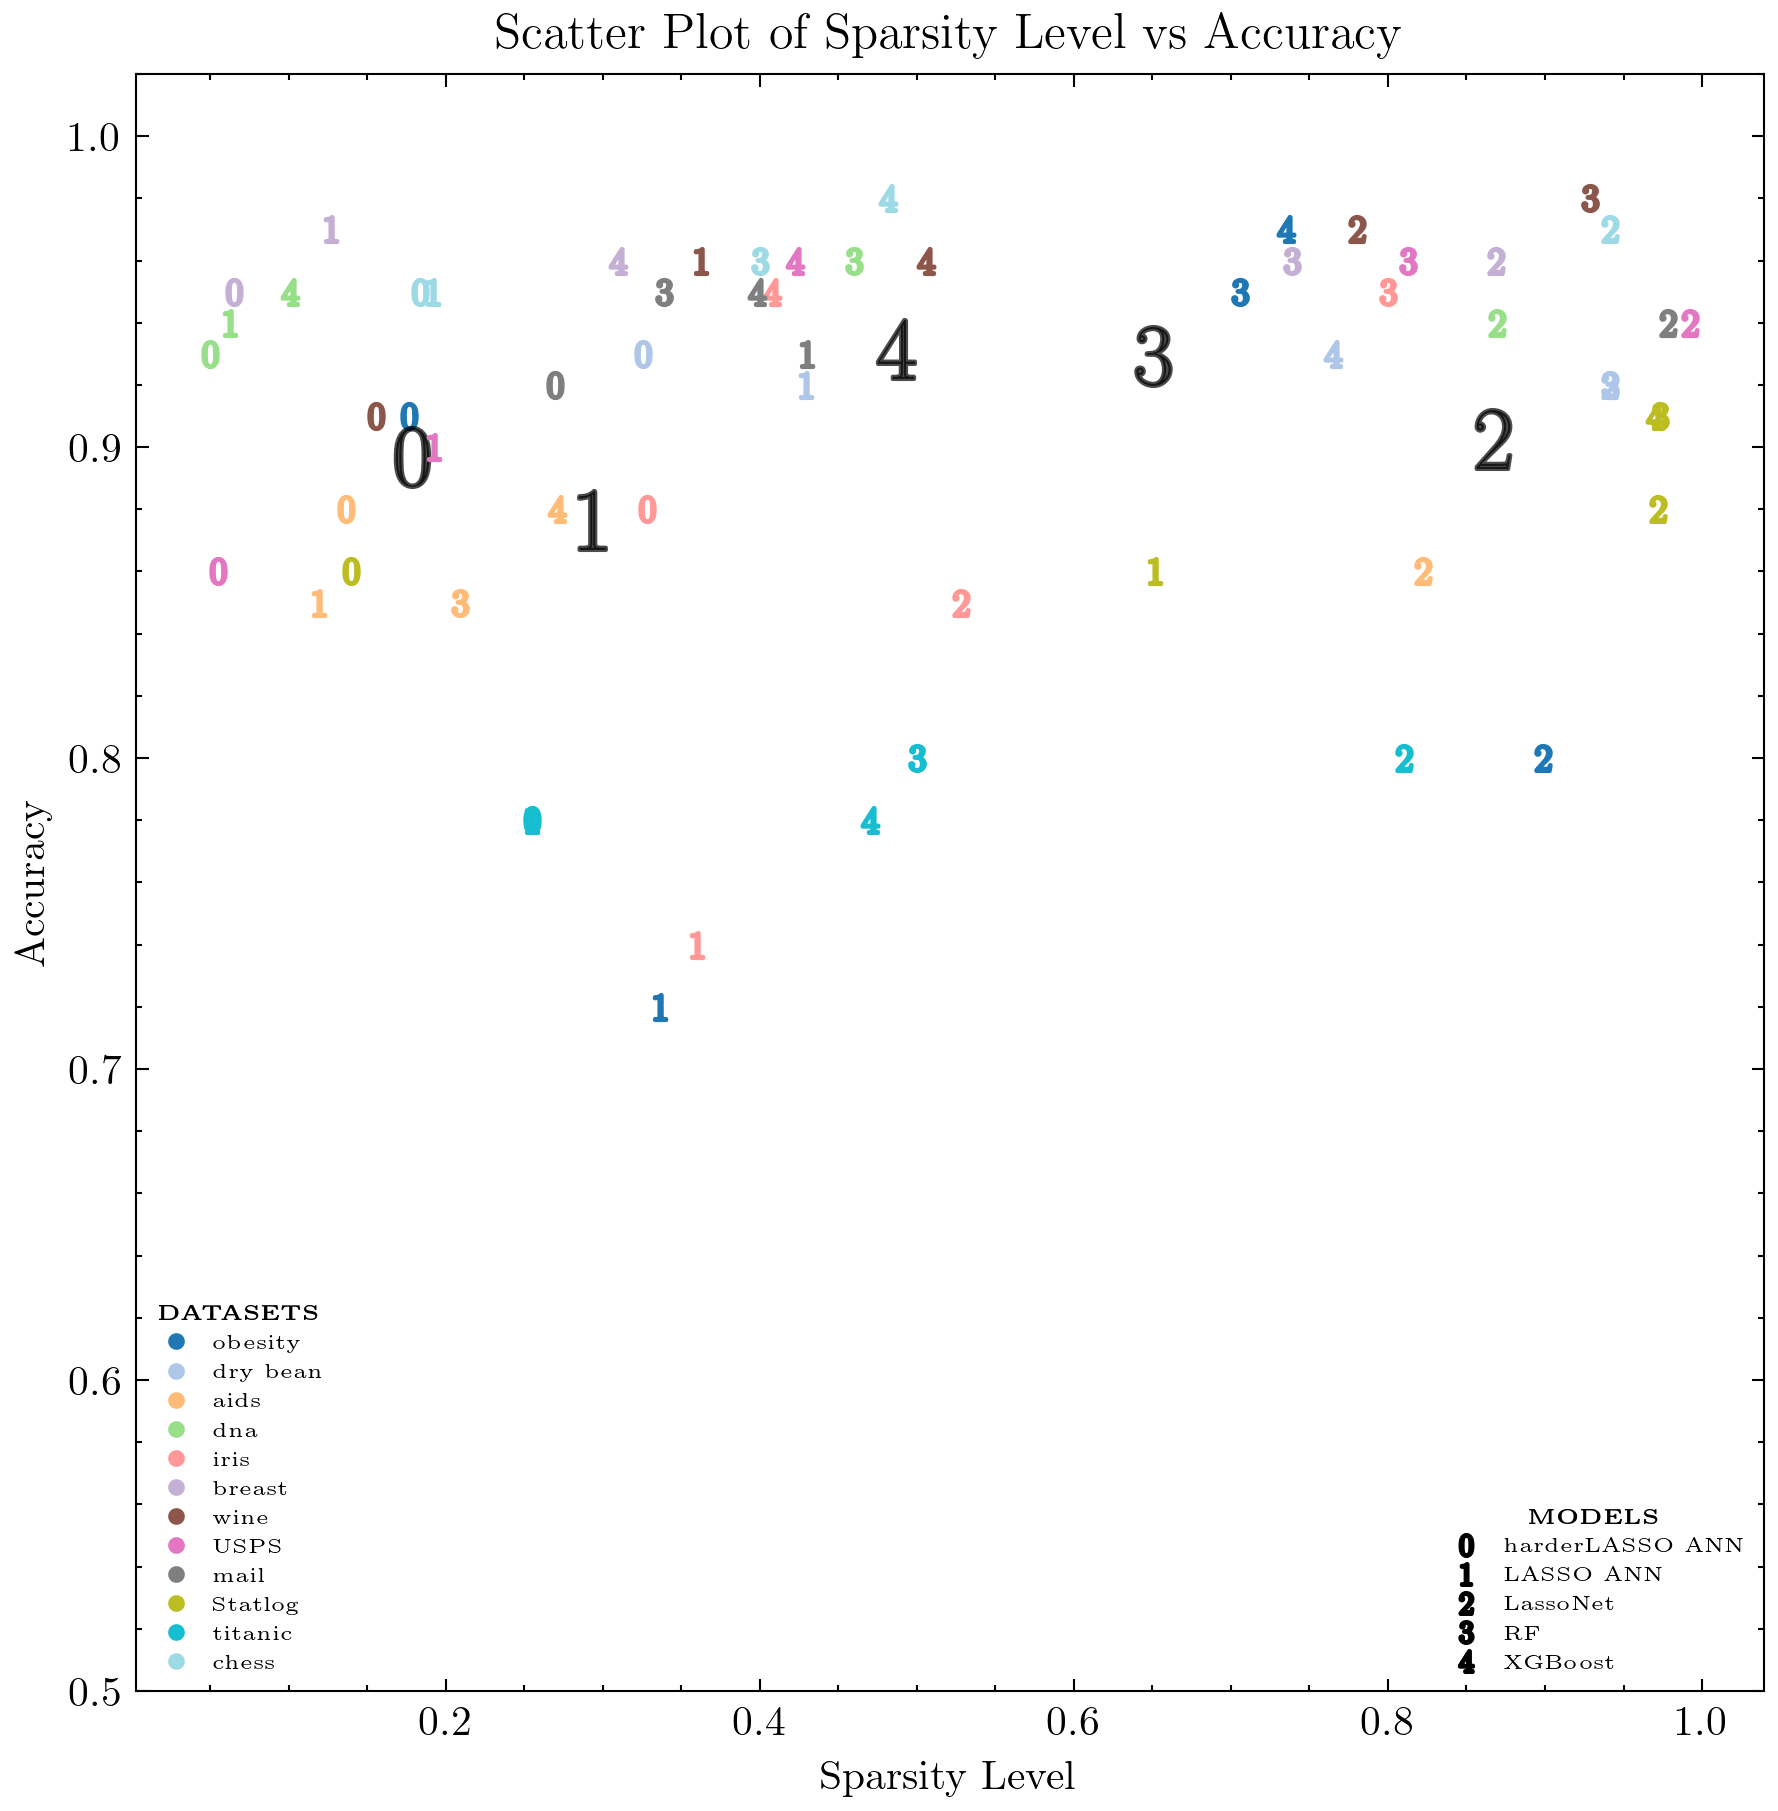

In [ ]:
plt.figure(figsize=(7, 7), dpi=300)
plotted_models = results_class.columns
total_values = {}
datasets = results_class.index
datasets_colors = {dataset: color for dataset, color in zip(datasets, cm.get_cmap('tab20', len(datasets)).colors)}
plotted_datasets = set()

# Plot the data points
for model in plotted_models:
    total_values = []
    model_results = results_class[model]
    for dataset in datasets:
        sparsity_level = model_results[dataset][0]/p_values[dataset]
        accuracy = model_results[dataset][1]

        label = dataset if dataset not in plotted_datasets else None
        plt.scatter(sparsity_level, accuracy, c=[datasets_colors[dataset]],
                    marker="$" + str(models[model]['id']) + "$", label=label)
        total_values.append((sparsity_level, accuracy))
        plotted_datasets.add(dataset)

    a, b = (np.mean([i[0] for i in total_values]), np.mean([i[1] for i in total_values]))
    plt.scatter(a, b, c='black', marker="$" + str(models[model]['id']) + "$", s=200, alpha=0.7)

# Create the datasets legend
datasets_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=datasets_colors[dataset], markersize=5, label=dataset)
                   for dataset in datasets if dataset in plotted_datasets]
legend_datasets = plt.legend(handles=datasets_legend, title=r"\bf{DATASETS}", loc="lower left", fontsize=5, title_fontsize=5)

# Create the models legend
models_legend = [Line2D([0], [0], marker="$" + str(models[model]['id']) + "$", color='black', linestyle='None', markersize=5, label=model) for model in plotted_models]
legend_models = plt.legend(handles=models_legend, title=r"\bf{MODELS}", loc="lower right", fontsize=5, title_fontsize=5)

# Add the datasets legend back to the plot
plt.gca().add_artist(legend_datasets)

# Labels, title, and saving
plt.ylim(0.5, 1.02)
plt.xlabel("Sparsity Level")
plt.ylabel("Accuracy")
plt.title("Scatter Plot of Sparsity Level vs Accuracy")
plt.savefig("classificationsimuresults.pdf")
plt.show()